In [49]:
import numpy as np
import keras
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# Iris dataset

### Dataset load and setting

In [2]:
# create object of class 'load_iris'
iris = load_iris()

In [3]:
# save features and targets from the 'iris'
features, targets = iris.data, iris.target


### Dataset Split into:
Train, test and validation

In [4]:
# Split: train_size=0.8 and test_size=0.2
# in a second split the test size will be split into two. 
# It will be 0.1 to test set  and 0.1 to validation set  
train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        random_state=23,
        stratify=targets
    )

In [5]:
 class_number = len(np.unique(targets))

In [6]:
# amount of classes to the problem
class_number

3

In [7]:
test_features.shape

(30, 4)

In [8]:
train_features.shape

(120, 4)

## Amount of half of the test's first split

In [9]:
half_test_samples = int((len(test_features))/2)

### Split of the test set into half

In [10]:
val_features = test_features[:half_test_samples]

In [11]:
val_features.shape

(15, 4)

In [12]:
val_targets = test_targets[:half_test_samples]

### Test set now is it's half size

In [13]:
test_features = test_features[half_test_samples:]

In [14]:
test_features.shape

(15, 4)

In [15]:
test_targets = test_targets[half_test_samples:]

In [16]:
test_targets

array([1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1])

## Model Creation

In [17]:
def create_MLP_model(classes_number):
    """
    Function to create a MLP model
    classes_number: Number of classes to be classified
    
    return model - model to be used in the training stage
    """
    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='sigmoid'))
    model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    return model

## Encoding classes

In [22]:
train_targets = keras.utils.np_utils.to_categorical(train_targets, class_number)
test_targets = keras.utils.np_utils.to_categorical(test_targets, class_number)
val_targets = keras.utils.np_utils.to_categorical(val_targets, class_number)

### Model compilation

In [23]:
model = create_MLP_model(class_number)

In [24]:
 model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
#variables and constants to the model training
callbacks_list = []
path_to_save_model = "model/best_model.h5"



### Callbacks

In [39]:
#model checkpoint to save just the best model with the lowest loss
model_checkpoint = ModelCheckpoint(path_to_save_model,
                                   monitor='val_loss',
                                   verbose=2,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

callbacks_list.append(model_checkpoint)

In [40]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=0,  
                                    patience=10,
                                    verbose=2,
                                    mode='auto',
                                    baseline=None,
                                    restore_best_weights=False)

callbacks_list.append(early_stop_callback)

In [42]:
history = model.fit(train_features,
                    train_targets,
                    batch_size=32,
                    epochs=100,
                    verbose=2,
                    callbacks = callbacks_list,
                    validation_data=(val_features, val_targets))

Train on 120 samples, validate on 15 samples
Epoch 1/100
 - 0s - loss: 0.1395 - acc: 0.9417 - val_loss: 0.0851 - val_acc: 1.0000

Epoch 00001: val_loss did not improve from 0.06479
Epoch 2/100
 - 0s - loss: 0.1451 - acc: 0.9500 - val_loss: 0.0962 - val_acc: 0.9333

Epoch 00002: val_loss did not improve from 0.06479
Epoch 3/100
 - 0s - loss: 0.1213 - acc: 0.9750 - val_loss: 0.0889 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.06479
Epoch 4/100
 - 0s - loss: 0.0978 - acc: 0.9750 - val_loss: 0.0596 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.06479 to 0.05959, saving model to model/best_model.h5
Epoch 5/100
 - 0s - loss: 0.0938 - acc: 0.9750 - val_loss: 0.0591 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.05959 to 0.05907, saving model to model/best_model.h5
Epoch 6/100
 - 0s - loss: 0.1147 - acc: 0.9750 - val_loss: 0.0849 - val_acc: 1.0000

Epoch 00006: val_loss did not improve from 0.05907
Epoch 7/100
 - 0s - loss: 0.1270 - acc: 0.9417 - val_loss

### Test saved model

In [44]:
model = load_model(path_to_save_model)

In [45]:
_, accuracy = model.evaluate(test_features, test_targets)

15/15 [==============================] - 0s 4ms/step


In [59]:
predictions = model.predict(test_features)

In [46]:
print('Accuracy: %.2f' % (accuracy*100))


Accuracy: 93.33


### Confusion Matrix

In [62]:
confusion_matrix(test_targets.argmax(axis=1), predictions.argmax(axis=1))

array([[5, 0, 0],
       [0, 5, 1],
       [0, 0, 4]])

### Accuracy and Loss plot

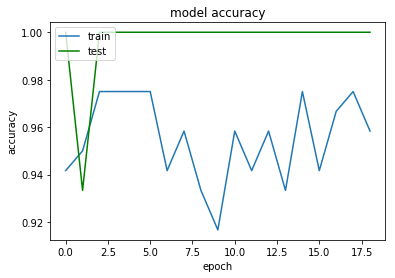

In [56]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], 'g')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accurary_1.png')

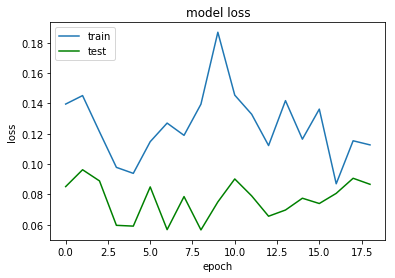

In [58]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss_1.png')